## Dependencies

In [1]:
import os
import shutil

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

## Paths and Configurations

In [2]:
print(os.listdir('/kaggle/'))
print(os.listdir('/kaggle/input/'))
print(os.listdir('/kaggle/input/hams10000'))

img_dir1 = '/kaggle/input/hams10000/HAM10000_images_part_1/'
img_dir2 = '/kaggle/input/hams10000/HAM10000_images_part_2/'
metadata_file = '/kaggle/input/hams10000/HAM10000_metadata'

['lib', 'input', 'working']
['hams10000']
['ISIC2018_Task3_Test_Images', 'HAM10000_segmentations_lesion_tschandl', 'ISIC2018_Task3_Test_NatureMedicine_AI_Interaction_Benefit.csv', 'ISIC2018_Task3_Test_GroundTruth.csv', 'HAM10000_images_part_1', 'HAM10000_metadata', 'HAM10000_images_part_2']


## Data Preprocessing

In [3]:
df = pd.read_csv(metadata_file)
print('Unique Diagnosis -', df['dx'].unique())
df.head(10)

Unique Diagnosis - ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,vidir_modern
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,vidir_modern


In [4]:
dx_full_form = {
    'bkl': 'Benign keratosis',
    'nv': 'Melanocytic nevi',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'vasc': 'Vascular skin lesion',
    'bcc': 'Basal cell carcinom',
    'akiec': 'Actinic Keratoses (Solar Keratoses) and Intraepithelial Carcinoma (Bowen’s disease)'
}

In [5]:
#   splitting into training and testing sets
#   One hot encoding on labels
y = df.pop('dx')
y = y.to_frame()
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
print('Training set shape X-', X_train.shape, 'y-', y_train.shape) 
print('Training set shape X-', X_test.shape, 'y-', y_test.shape)
print(y_train.value_counts())

Training set shape X- (7511, 7) y- (7511, 1)
Training set shape X- (2504, 7) y- (2504, 1)
dx   
nv       5029
mel       835
bkl       824
bcc       385
akiec     245
vasc      107
df         86
Name: count, dtype: int64


In [6]:
# Data Augmentation to address the class imbalancce
max_samples = y_train.value_counts().max()
resample_count = int(0.7*max_samples)
oversample_strategy = {
    'bkl': resample_count,
    'nv': max_samples,
    'df': resample_count,
    'mel': resample_count,
    'vasc': resample_count,
    'bcc': resample_count,
    'akiec': resample_count
}

oversample_data = RandomOverSampler(sampling_strategy=oversample_strategy)
undersample_data = RandomUnderSampler()
X_train, y_train = oversample_data.fit_resample(X_train, y_train)
print('After Oversampling')
print(y_train.value_counts(),'\n')
# X_train, y_train = undersample_data.fit_resample(X_train, y_train)
# print('After UnderSampling')
# print(y_train.value_counts(),'\n')

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()
y_test = encoder.transform(y_test).toarray()

print('Training set shape X-', X_train.shape, 'y-', y_train.shape) 
print('Training set shape X-', X_test.shape, 'y-', y_test.shape)

After Oversampling
dx   
nv       5029
bcc      3520
akiec    3520
bkl      3520
df       3520
mel      3520
vasc     3520
Name: count, dtype: int64 

Training set shape X- (26149, 7) y- (26149, 7)
Training set shape X- (2504, 7) y- (2504, 7)


## Custom Dataset

In [7]:
# custom dataset for returning tuples of imgs and labels
class SkinLesionsDataset(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_name = self.X.iloc[idx]['image_id']
        label = self.y[idx]
        if os.path.exists(f'{img_dir1}{img_name}.jpg'):
            img_dir = img_dir1
        else:
            img_dir = img_dir2
        img = Image.open(f'{img_dir}{img_name}.jpg')
        if self.transform is not None:
            img = self.transform(img)
        return img, label

## Model Architecture

In [77]:
# CNN Model Architecture 1
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # feature extraction with Convolutions, Relu, and max_pooling layers
        self.conv1 = nn.Conv2d(3, 24, 3)
        self.conv2 = nn.Conv2d(24, 18, 3)
        self.conv3 = nn.Conv2d(18, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)

        # classification with linear layers
        self.linear1 = nn.Linear(6*59*59, 4096)
        self.linear2 = nn.Linear(4096, 512)
        self.linear3 = nn.Linear(512, 128)
        # no softamx activation needed bacause we are using Cross Entropy loss
        # In pytorch, it includes softmax
        self.linear4 = nn.Linear(128, 7) # 7 classes
        
    def forward(self, x):
        # input size = (3,128,128)
        x = nn.functional.relu(self.conv1(x))  # Output size = (24,126,126)
        x = self.pool(x)  # Output size = (24,63,63)
        x = nn.functional.relu(self.conv2(x))  # Output size = (18,61,61)
        x = nn.functional.relu(self.conv3(x))  # Output size = (6,59,59)
        x = torch.flatten(x,1)  # Output size = (1,6*59*59)
        x = nn.functional.relu(self.linear1(x))  # Output size = (1,4096)
        x = nn.functional.relu(self.linear2(x))  # Output size = (1,512)
        x = nn.functional.relu(self.linear3(x))  # Output size = (1,128)
        x = self.linear4(x)  # Output size = (1,7)
        return x

In [14]:
# CNN Model Architecture 1
class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()

        # Feature extraction
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Same padding
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Classification
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 7)  # 7 classes

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.pool2(nn.functional.relu(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Training Loop

In [9]:
def train_model(model, optimizer, loss_func, num_epochs, device, train_dataloader, test_dataloader):
    print('Training started...')
    print('==============================================================')
    losses = []
    train_accuracies = []
    test_accuracies = []
    for current_epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0
        for i, (batch_images, batch_labels) in enumerate(train_dataloader):
            imgs =  batch_images.to(device)
            labels = batch_labels.clone().detach().to(device)
            # Forward pass, get the output from the model and
            # calculate the loss by comparing the model output and true labels
            model_output = model(imgs)
            loss = loss_func(model_output, labels)
            
            # Backpropagate the calculated loss
            optimizer.zero_grad() #zeroing the gradients
            loss.backward()
            optimizer.step()

            # update running loss and accuracy
            running_loss += loss.item()
            _, predictions = torch.max(model_output, 1)  # Get the higest probability predictions
            _,labels = torch.max(labels,1)
            total_train_predictions += len(predictions)
            correct_train_predictions += (predictions ==labels).sum().item()

        # evaluate the model after every epoch
        model.eval()
        correct_test_predictions = 0
        total_test_predictions = 0

        with torch.no_grad():
            for i, (batch_images, batch_labels) in enumerate(test_dataloader):
                imgs =  batch_images.to(device)
                labels = batch_labels.clone().detach().to(device)
                # Forward pass, get the output from the model and
                model_output = model(imgs)

                # calculating the accuracies
                _, predictions = torch.max(model_output, 1)  # Get the higest probability predictions
                _,labels = torch.max(labels,1)
                total_test_predictions += len(predictions)
                correct_test_predictions += (predictions ==labels).sum().item() 

        running_loss = running_loss/len(train_dataloader)
        train_accuracy = correct_train_predictions/total_train_predictions
        test_accuracy = correct_test_predictions/total_test_predictions
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        losses.append(running_loss)
        
        print(f'Epoch [{current_epoch+1}/{num_epochs}] - ')
        print(f'   Training Accuracy: {round(train_accuracy*100,4)}% Validation Accuracy: {round(test_accuracy*100,4)}% Loss: {running_loss}')
    
    print('==============================================================')
    print('Training Completed!')
    
    return model, losses, train_accuracies, test_accuracies

In [16]:
def vit_train_model(model, optimizer, loss_func, num_epochs, device, train_dataloader, test_dataloader):
    print('Training started...')
    print('==============================================================')
    losses = []
    train_accuracies = []
    test_accuracies = []
    for current_epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0
        for i, (batch_images, batch_labels) in enumerate(train_dataloader):
            imgs =  batch_images.to(device)
            labels = batch_labels.clone().detach().to(device)
            # Forward pass, get the output from the model and
            # calculate the loss by comparing the model output and true labels
            model_output = model(imgs)
            _,labels = torch.max(labels,1)
            loss = loss_func(model_output, labels)
            
            # Backpropagate the calculated loss
            optimizer.zero_grad() #zeroing the gradients
            loss.backward()
            optimizer.step()

            # update running loss and accuracy
            running_loss += loss.item()
            _, predictions = torch.max(model_output, 1)  # Get the higest probability predictions
            total_train_predictions += len(predictions)
            correct_train_predictions += (predictions ==labels).sum().item()

        # evaluate the model after every epoch
        model.eval()
        correct_test_predictions = 0
        total_test_predictions = 0

        with torch.no_grad():
            for i, (batch_images, batch_labels) in enumerate(test_dataloader):
                imgs =  batch_images.to(device)
                labels = batch_labels.clone().detach().to(device)
                # Forward pass, get the output from the model and
                model_output = model(imgs)

                # calculating the accuracies
                _, predictions = torch.max(model_output, 1)  # Get the higest probability predictions
                _,labels = torch.max(labels,1)
                total_test_predictions += len(predictions)
                correct_test_predictions += (predictions ==labels).sum().item() 

        running_loss = running_loss/len(train_dataloader)
        train_accuracy = correct_train_predictions/total_train_predictions
        test_accuracy = correct_test_predictions/total_test_predictions
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        losses.append(running_loss)
        
        print(f'Epoch [{current_epoch+1}/{num_epochs}] - ')
        print(f'   Training Accuracy: {round(train_accuracy*100,4)}% Validation Accuracy: {round(test_accuracy*100,4)}% Loss: {running_loss}')
    
    print('==============================================================')
    print('Training Completed!')
    
    return model, losses, train_accuracies, test_accuracies

In [11]:
def plot_training_metrics(train_losses, train_accuacies, test_accuracies, epochs):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

    ax1.plot(range(epochs), train_accuacies, label='Training Accuracy')
    ax1.plot(range(epochs), test_accuracies, label='Testing Accuracy')
    ax1.set_title('Training and Testing Accuracies Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plotting losses on the second subplot
    ax2.plot(range(epochs), train_losses)
    ax2.set_title('Training Loss Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

## Training models

Training started...
Epoch [1/10] - 
   Training Accuracy: 22.2646% Validation Accuracy: 33.9856% Loss: 1.8265633881239676
Epoch [2/10] - 
   Training Accuracy: 36.7127% Validation Accuracy: 44.4888% Loss: 1.5604718418006251
Epoch [3/10] - 
   Training Accuracy: 53.0519% Validation Accuracy: 55.8706% Loss: 1.2085872707757552
Epoch [4/10] - 
   Training Accuracy: 65.5114% Validation Accuracy: 57.7476% Loss: 0.8907360772078466
Epoch [5/10] - 
   Training Accuracy: 75.5114% Validation Accuracy: 54.2732% Loss: 0.6442919542756849
Epoch [6/10] - 
   Training Accuracy: 82.8044% Validation Accuracy: 52.2364% Loss: 0.460466192738516
Epoch [7/10] - 
   Training Accuracy: 89.0747% Validation Accuracy: 56.0304% Loss: 0.2991226604902579
Epoch [8/10] - 
   Training Accuracy: 92.3701% Validation Accuracy: 62.2204% Loss: 0.21238145108302267
Epoch [9/10] - 
   Training Accuracy: 93.5024% Validation Accuracy: 63.2588% Loss: 0.19005927439350317
Epoch [10/10] - 
   Training Accuracy: 94.2045% Validation Ac

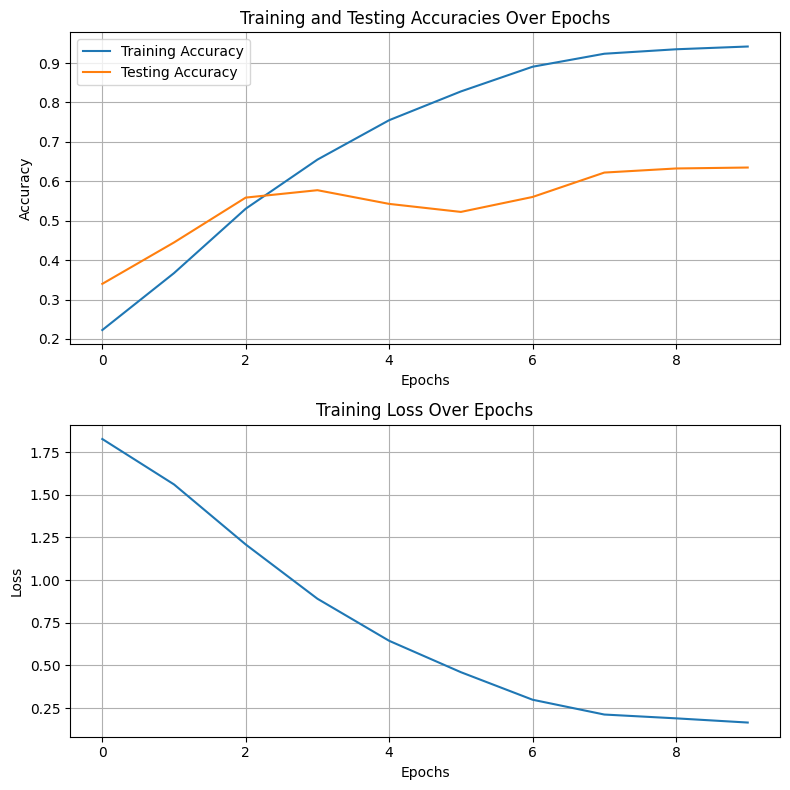

In [80]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
batch_size = 356
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

training_dataset = SkinLesionsDataset(X_train, y_train, transform=train_transform)
testing_dataset = SkinLesionsDataset(X_test, y_test, transform=test_transform)

train_dataloader = DataLoader(training_dataset, batch_size, shuffle = True)
test_dataloader = DataLoader(testing_dataset, batch_size, shuffle = True)

model = CNNModel().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

trained_model, losses, train_accuracies, test_accuracies = train_model(model, optimizer, loss_function, num_epochs, device, train_dataloader, test_dataloader)
plot_training_metrics(losses, train_accuracies, test_accuracies, num_epochs)

torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

Training started...
Epoch [1/10] - 
   Training Accuracy: 44.0706% Validation Accuracy: 48.0431% Loss: 1.4667417412168342
Epoch [2/10] - 
   Training Accuracy: 53.5187% Validation Accuracy: 45.8067% Loss: 1.2329620746002792
Epoch [3/10] - 
   Training Accuracy: 57.9221% Validation Accuracy: 46.3658% Loss: 1.1261947227471911
Epoch [4/10] - 
   Training Accuracy: 61.392% Validation Accuracy: 53.9936% Loss: 1.023516809315817
Epoch [5/10] - 
   Training Accuracy: 64.233% Validation Accuracy: 60.2236% Loss: 0.9574384589556614
Epoch [6/10] - 
   Training Accuracy: 67.2443% Validation Accuracy: 54.1534% Loss: 0.881194556713582
Epoch [7/10] - 
   Training Accuracy: 68.5714% Validation Accuracy: 36.3818% Loss: 0.8315186444167757
Epoch [8/10] - 
   Training Accuracy: 70.8117% Validation Accuracy: 43.1709% Loss: 0.7856867301825717
Epoch [9/10] - 
   Training Accuracy: 71.9278% Validation Accuracy: 57.7077% Loss: 0.7499534784753304
Epoch [10/10] - 
   Training Accuracy: 72.6664% Validation Accurac

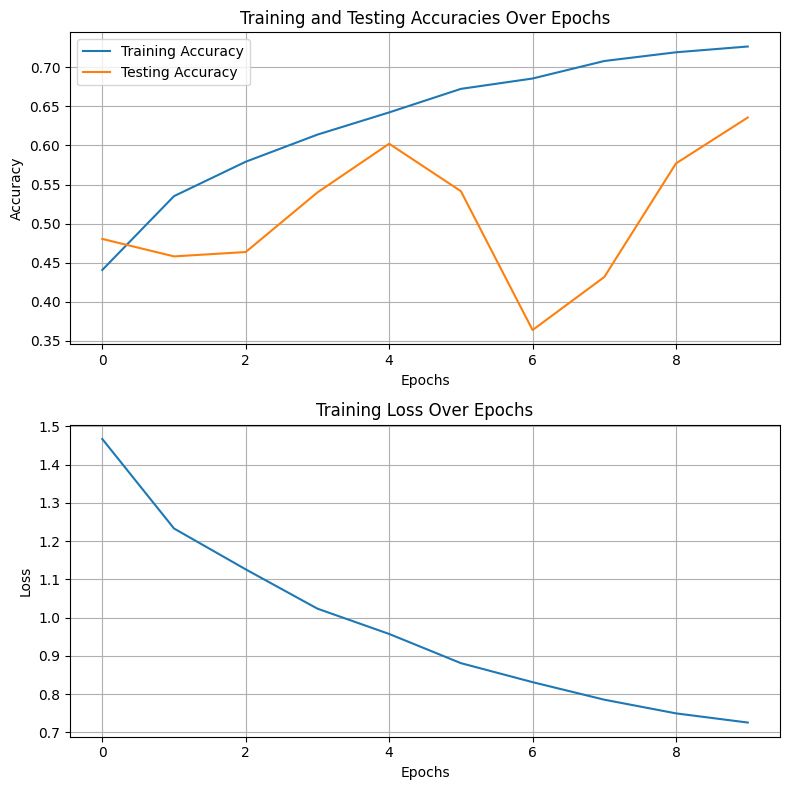

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 20
batch_size = 356
train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomRotation(degrees=(0, 180)),
#     transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

training_dataset = SkinLesionsDataset(X_train, y_train, transform=train_transform)
testing_dataset = SkinLesionsDataset(X_test, y_test, transform=test_transform)

train_dataloader = DataLoader(training_dataset, batch_size, shuffle = True)
test_dataloader = DataLoader(testing_dataset, batch_size, shuffle = True)

model = CNNModel2().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

trained_model, losses, train_accuracies, test_accuracies = train_model(model, optimizer, loss_function, num_epochs, device, train_dataloader, test_dataloader)
plot_training_metrics(losses, train_accuracies, test_accuracies, num_epochs)

del training_dataset, testing_dataset, train_dataloader, test_dataloader, model, loss_function, optimizer
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

## Transfer Learning

In [17]:
model_list = [model for model in dir(models) if not model.startswith("__")]
print(model_list)

['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights', 'ConvNeXt_Small_Weights', 'ConvNeXt_Tiny_Weights', 'DenseNet', 'DenseNet121_Weights', 'DenseNet161_Weights', 'DenseNet169_Weights', 'DenseNet201_Weights', 'EfficientNet', 'EfficientNet_B0_Weights', 'EfficientNet_B1_Weights', 'EfficientNet_B2_Weights', 'EfficientNet_B3_Weights', 'EfficientNet_B4_Weights', 'EfficientNet_B5_Weights', 'EfficientNet_B6_Weights', 'EfficientNet_B7_Weights', 'EfficientNet_V2_L_Weights', 'EfficientNet_V2_M_Weights', 'EfficientNet_V2_S_Weights', 'GoogLeNet', 'GoogLeNetOutputs', 'GoogLeNet_Weights', 'Inception3', 'InceptionOutputs', 'Inception_V3_Weights', 'MNASNet', 'MNASNet0_5_Weights', 'MNASNet0_75_Weights', 'MNASNet1_0_Weights', 'MNASNet1_3_Weights', 'MaxVit', 'MaxVit_T_Weights', 'MobileNetV2', 'MobileNetV3', 'MobileNet_V2_Weights', 'MobileNet_V3_Large_Weights', 'MobileNet_V3_Small_Weights', 'RegNet', 'RegNet_X_16GF_Weights', 'RegNet_X_1_6GF_Weights', 'RegNet_X_32GF_

### ResNet

Training started...
Epoch [1/10] - 
   Training Accuracy: 75.2878% Validation Accuracy: 71.3658% Loss: 0.6630517587392954
Epoch [2/10] - 
   Training Accuracy: 84.0223% Validation Accuracy: 77.8754% Loss: 0.4240169440544858
Epoch [3/10] - 
   Training Accuracy: 87.6707% Validation Accuracy: 72.1645% Loss: 0.3269713779332064
Epoch [4/10] - 
   Training Accuracy: 89.1965% Validation Accuracy: 78.5144% Loss: 0.2848240634654943
Epoch [5/10] - 
   Training Accuracy: 90.8945% Validation Accuracy: 80.4712% Loss: 0.24186574658514365
Epoch [6/10] - 
   Training Accuracy: 91.9423% Validation Accuracy: 77.1965% Loss: 0.21494922123864044
Epoch [7/10] - 
   Training Accuracy: 93.3688% Validation Accuracy: 79.1134% Loss: 0.17897220061265992
Epoch [8/10] - 
   Training Accuracy: 93.4529% Validation Accuracy: 84.345% Loss: 0.1771915160138815
Epoch [9/10] - 
   Training Accuracy: 94.4204% Validation Accuracy: 77.7157% Loss: 0.14753199377727041
Epoch [10/10] - 
   Training Accuracy: 94.9138% Validation 

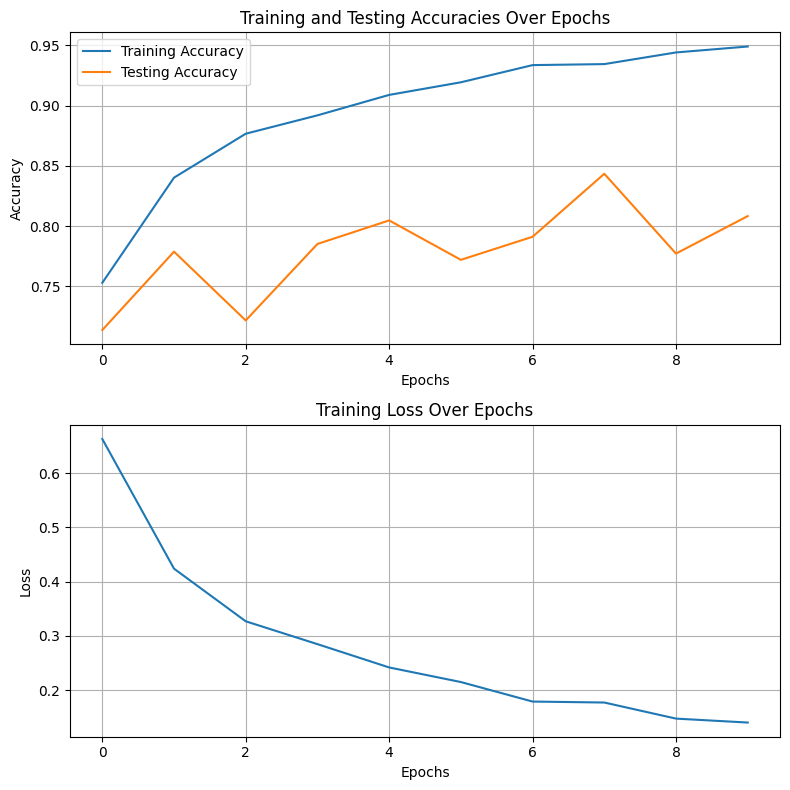

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
batch_size = 128
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

training_dataset = SkinLesionsDataset(X_train, y_train, transform=train_transform)
testing_dataset = SkinLesionsDataset(X_test, y_test, transform=test_transform)

train_dataloader = DataLoader(training_dataset, batch_size, shuffle = True)
test_dataloader = DataLoader(testing_dataset, batch_size, shuffle = True)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features # get the output features from the last layer of the pretrained model
model.fc = nn.Linear(num_ftrs, 7) # replace the last layer with a linear head, 7 output nodes
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

trained_model, losses, train_accuracies, test_accuracies = train_model(model, optimizer, loss_function, num_epochs, device, train_dataloader, test_dataloader)
plot_training_metrics(losses, train_accuracies, test_accuracies, num_epochs)

torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 62.2MB/s]


Training started...
Epoch [1/10] - 
   Training Accuracy: 72.4675% Validation Accuracy: 65.8546% Loss: 0.7331453760554727
Epoch [2/10] - 
   Training Accuracy: 82.1347% Validation Accuracy: 62.1406% Loss: 0.4800014505545392
Epoch [3/10] - 
   Training Accuracy: 85.5032% Validation Accuracy: 57.0687% Loss: 0.39084992741197516
Epoch [4/10] - 
   Training Accuracy: 88.1494% Validation Accuracy: 49.4808% Loss: 0.31852923040480063
Epoch [5/10] - 
   Training Accuracy: 89.5739% Validation Accuracy: 65.5751% Loss: 0.28486853476182594
Epoch [6/10] - 
   Training Accuracy: 90.625% Validation Accuracy: 75.0799% Loss: 0.2523842085588327
Epoch [7/10] - 
   Training Accuracy: 91.8425% Validation Accuracy: 64.377% Loss: 0.21974301073869223
Epoch [8/10] - 
   Training Accuracy: 93.1656% Validation Accuracy: 77.476% Loss: 0.18606482570072008
Epoch [9/10] - 
   Training Accuracy: 93.8231% Validation Accuracy: 55.8706% Loss: 0.16970667856364396
Epoch [10/10] - 
   Training Accuracy: 93.7297% Validation 

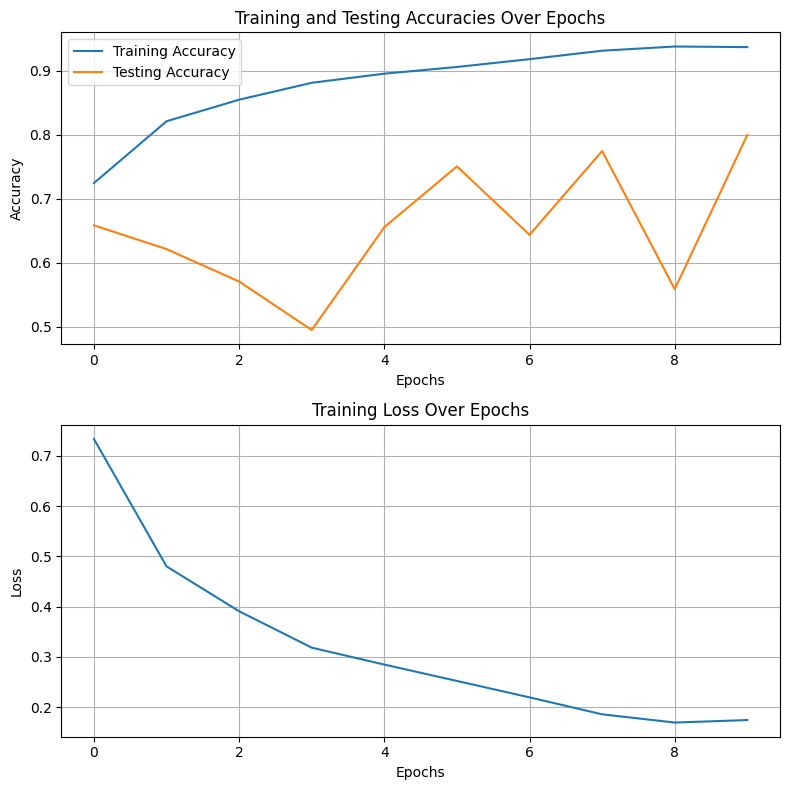

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
batch_size = 128
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

training_dataset = SkinLesionsDataset(X_train, y_train, transform=train_transform)
testing_dataset = SkinLesionsDataset(X_test, y_test, transform=test_transform)

train_dataloader = DataLoader(training_dataset, batch_size, shuffle = True)
test_dataloader = DataLoader(testing_dataset, batch_size, shuffle = True)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features # get the output features from the last layer of the pretrained model
model.fc = nn.Linear(num_ftrs, 7) # replace the last layer with a linear head, 7 output nodes
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

trained_model, losses, train_accuracies, test_accuracies = train_model(model, optimizer, loss_function, num_epochs, device, train_dataloader, test_dataloader)
plot_training_metrics(losses, train_accuracies, test_accuracies, num_epochs)

torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

### EfficientNet

In [16]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Training started...
Epoch [1/10] - 
   Training Accuracy: 82.8368% Validation Accuracy: 81.9489% Loss: 0.4709621862512999
Epoch [2/10] - 
   Training Accuracy: 92.799% Validation Accuracy: 83.3866% Loss: 0.19632824388791342
Epoch [3/10] - 
   Training Accuracy: 95.0629% Validation Accuracy: 87.1805% Loss: 0.1365398300706382
Epoch [4/10] - 
   Training Accuracy: 96.4396% Validation Accuracy: 85.9425% Loss: 0.09906233204282655
Epoch [5/10] - 
   Training Accuracy: 96.9138% Validation Accuracy: 86.1022% Loss: 0.08420664803212163
Epoch [6/10] - 
   Training Accuracy: 97.5984% Validation Accuracy: 87.5% Loss: 0.06764895738300919
Epoch [7/10] - 
   Training Accuracy: 97.6519% Validation Accuracy: 86.7013% Loss: 0.06755023476898855
Epoch [8/10] - 
   Training Accuracy: 98.4474% Validation Accuracy: 87.2204% Loss: 0.045809416085318536
Epoch [9/10] - 
   Training Accuracy: 98.6003% Validation Accuracy: 86.1022% Loss: 0.04138350357954289
Epoch [10/10] - 
   Training Accuracy: 98.543% Validation 

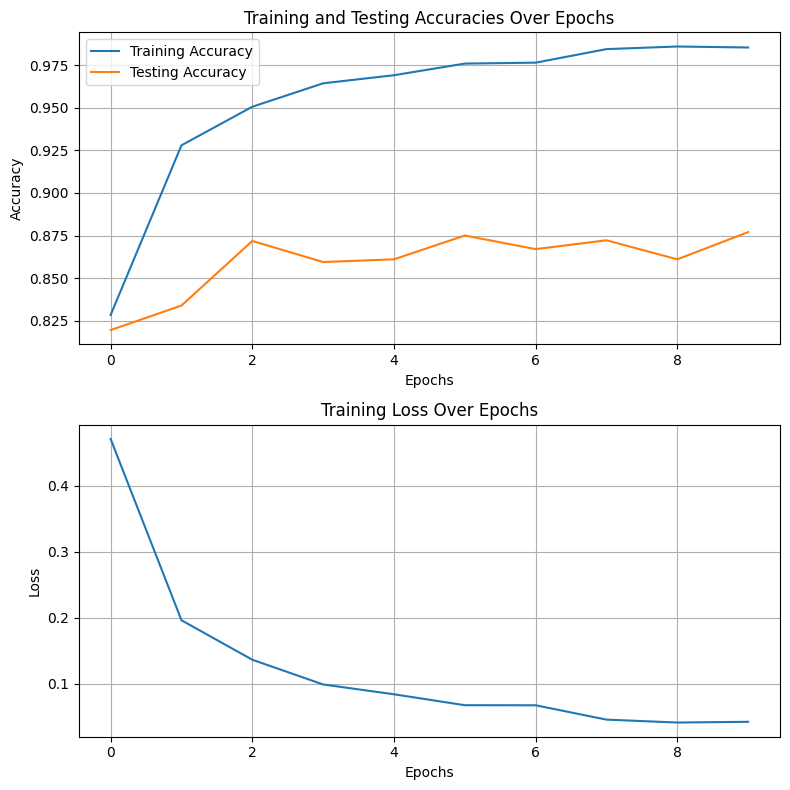

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
batch_size = 128
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

training_dataset = SkinLesionsDataset(X_train, y_train, transform=train_transform)
testing_dataset = SkinLesionsDataset(X_test, y_test, transform=test_transform)

train_dataloader = DataLoader(training_dataset, batch_size, shuffle = True)
test_dataloader = DataLoader(testing_dataset, batch_size, shuffle = True)

model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
num_ftrs = model.classifier[1].in_features # get the output features from the last layer of the pretrained model
model.classifier[1] = nn.Linear(in_features=num_ftrs, out_features=7) # replace the last layer with a linear head, 7 output nodes
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

trained_model, losses, train_accuracies, test_accuracies = train_model(model, optimizer, loss_function, num_epochs, device, train_dataloader, test_dataloader)
plot_training_metrics(losses, train_accuracies, test_accuracies, num_epochs)

torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

### Mobilenet

In [15]:
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:01<00:00, 5.82MB/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

Training started...
Epoch [1/10] - 
   Training Accuracy: 79.4256% Validation Accuracy: 57.7077% Loss: 0.5398345240682869
Epoch [2/10] - 
   Training Accuracy: 90.405% Validation Accuracy: 72.8435% Loss: 0.25739091082845483
Epoch [3/10] - 
   Training Accuracy: 93.4108% Validation Accuracy: 81.6294% Loss: 0.17775611609507477
Epoch [4/10] - 
   Training Accuracy: 94.9023% Validation Accuracy: 82.3882% Loss: 0.1404452645792635
Epoch [5/10] - 
   Training Accuracy: 96.1146% Validation Accuracy: 79.7923% Loss: 0.11117215358406843
Epoch [6/10] - 
   Training Accuracy: 96.5276% Validation Accuracy: 82.9872% Loss: 0.09724233085268369
Epoch [7/10] - 
   Training Accuracy: 97.1127% Validation Accuracy: 82.9473% Loss: 0.08070228226921122
Epoch [8/10] - 
   Training Accuracy: 97.5793% Validation Accuracy: 83.0272% Loss: 0.06802321795832127
Epoch [9/10] - 
   Training Accuracy: 97.7628% Validation Accuracy: 84.8243% Loss: 0.06267124442801644
Epoch [10/10] - 
   Training Accuracy: 97.9081% Validati

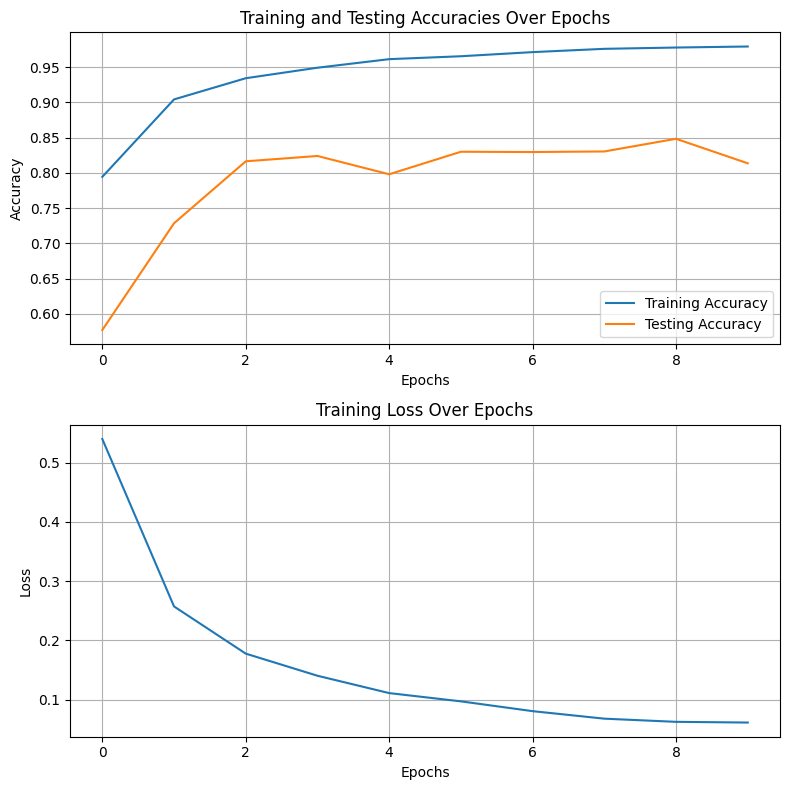

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
batch_size = 128
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

training_dataset = SkinLesionsDataset(X_train, y_train, transform=train_transform)
testing_dataset = SkinLesionsDataset(X_test, y_test, transform=test_transform)

train_dataloader = DataLoader(training_dataset, batch_size, shuffle = True)
test_dataloader = DataLoader(testing_dataset, batch_size, shuffle = True)

model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
num_ftrs = model.classifier[3].in_features # get the output features from the last layer of the pretrained model
model.classifier[3] = nn.Linear(in_features=num_ftrs, out_features=7) # replace the last layer with a linear head, 7 output nodes
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

trained_model, losses, train_accuracies, test_accuracies = train_model(model, optimizer, loss_function, num_epochs, device, train_dataloader, test_dataloader)
plot_training_metrics(losses, train_accuracies, test_accuracies, num_epochs)

torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

### Vision Transformer

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Training started...
Epoch [1/10] - 
   Training Accuracy: 47.5085% Validation Accuracy: 57.3083% Loss: 1.4168411436465667
Epoch [2/10] - 
   Training Accuracy: 67.9452% Validation Accuracy: 58.9457% Loss: 0.8355468941492673
Epoch [3/10] - 
   Training Accuracy: 74.4464% Validation Accuracy: 59.6246% Loss: 0.6641338468326624
Epoch [4/10] - 
   Training Accuracy: 77.2649% Validation Accuracy: 64.0974% Loss: 0.5993352725846843
Epoch [5/10] - 
   Training Accuracy: 78.3778% Validation Accuracy: 66.1342% Loss: 0.580095962382179
Epoch [6/10] - 
   Training Accuracy: 81.6934% Validation Accuracy: 66.7732% Loss: 0.4833534933754168
Epoch [7/10] - 
   Training Accuracy: 81.3415% Validation Accuracy: 63.2588% Loss: 0.4942189729738352
Epoch [8/10] - 
   Training Accuracy: 83.1007% Validation Accuracy: 58.4265% Loss: 0.4531713257427612
Epoch [9/10] - 
   Training Accuracy: 83.7776% Validation Accuracy: 60.9026% Loss: 0.4311430546794369
Epoch [10/10] - 
   Training Accuracy: 83.1581% Validation Accu

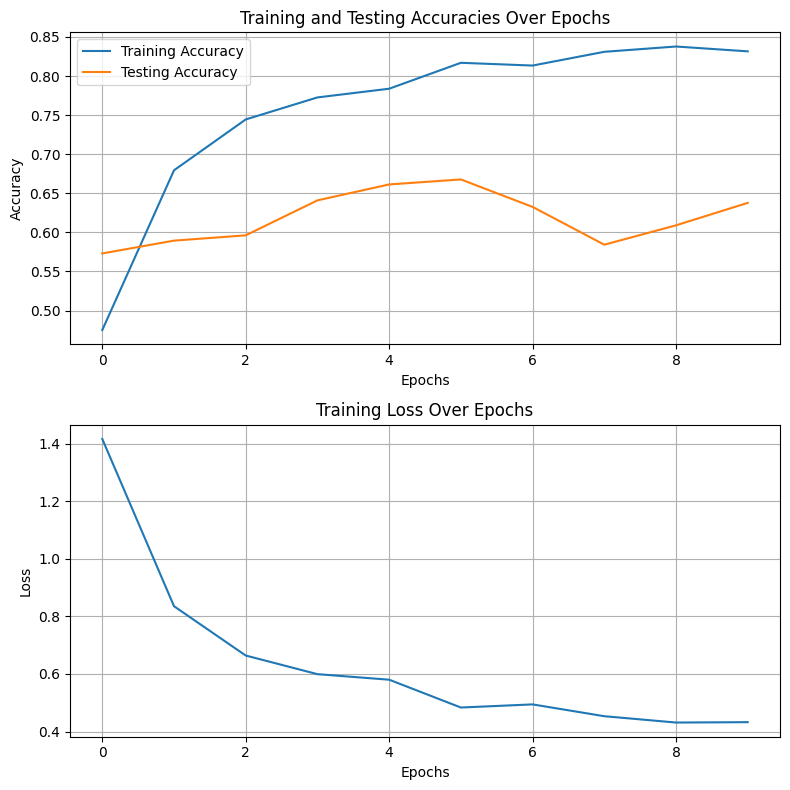

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
batch_size = 64
lr = 0.0005

model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 7)
model = model.to(device)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

training_dataset = SkinLesionsDataset(X_train, y_train, transform=transform)
testing_dataset = SkinLesionsDataset(X_test, y_test, transform=transform)

train_dataloader = DataLoader(training_dataset, batch_size, shuffle = True)
test_dataloader = DataLoader(testing_dataset, batch_size, shuffle = True)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

trained_model, losses, train_accuracies, test_accuracies = vit_train_model(model, optimizer, loss_function, num_epochs, device, train_dataloader, test_dataloader)
plot_training_metrics(losses, train_accuracies, test_accuracies, num_epochs)

torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

### Next Steps
* Try some simpler models like Alexnet, small Mobilenet, EfficientNetB1
* Try learning rate and weight decay (regularization)
* Add some dropout layers after the original model layers
* Early Stopping and save the model